In [56]:
!pip install --upgrade pandas seaborn tdqm google-generativeai tiktoken wordcloud

In [1]:
import pandas as pd
import glob
import csv
import re
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm
import google.generativeai as genai
from google.api_core.exceptions import ResourceExhausted
import json
from tqdm.auto import tqdm
import re
import tiktoken
import networkx as nx
from wordcloud import WordCloud
import getpass
tqdm.pandas()

In [2]:
genai.configure(api_key=getpass.getpass(prompt='Please enter your Gogle Studio API key: '))

Please enter your Gogle Studio API key:  ········


In [3]:
gemini_pro = genai.GenerativeModel('gemini-1.5-pro-latest')
gemini_flash = genai.GenerativeModel('gemini-1.5-flash-latest')

In [4]:
dfs = []

def read_file(file):
    try:
        return open(directory + file + ".txt", "r").read()
    except:
        return None


for info_file in glob.glob("RusLit/**/info.csv", recursive=True):
    try:
        directory = info_file[:-8]
        info = pd.read_csv(info_file)
        info["author"] = directory.split("/")[2]
        info["type"] = directory.split("/")[1]
        info["text"] = info["name"].map(read_file)
        dfs.append(info)
    except:
        pass

df = pd.concat(dfs, ignore_index=True).dropna()
df["year"] = (
    df["year"].astype(str).map(lambda x: x.split("-")[0].split(".")[0]).astype(int)
)
df = df.dropna()

In [5]:
enc = tiktoken.encoding_for_model("gpt-4o")

df_chekhov = df[df["author"] == "Chekhov"].copy()
df_chekhov["tokens"] = df_chekhov["text"].apply(lambda text: len(enc.encode(text)))
df_chekhov = df_chekhov[df_chekhov["tokens"] < 60000]

with open('chekhov.json', 'w') as file:
    json.dump(df_chekhov.set_index('name')['text'].to_dict(), file)

In [18]:
retry_limit = 5

def get_genres(row):
    try:
        for attempt in range(retry_limit):
            try:
                return (
                    gemini_flash.generate_content(
                        row["text"]
                        + "Please provide a comma-separated list of single-word genres from the following list that best describe the text above: Realism, Romanticism, Symbolism, Modernism, Socialist Realism, Science Fiction, Gothic, Satire, Epic, Drama, Mystery and Detective Fiction\n"
                    )
                    .text
                )
            except ResourceExhausted:
                time.sleep(60)
    except ValueError:
        print("ValueError on " + row["name"])
    except InternalServerError:
        print("InternalServerError on " + row["name"])
    try:
        for attempt in range(retry_limit):
            try:
                return (
                    gemini_flash.generate_content(
                        row["name"]
                        + "Please provide a comma-separated list of single-word genres from the following list that best describe the text above: Realism, Romanticism, Symbolism, Modernism, Socialist Realism, Science Fiction, Gothic, Satire, Epic, Drama, Mystery and Detective Fiction\n"
                    )
                    .text
                )
            except ResourceExhausted:
                time.sleep(60)
    except ValueError:
        print("ValueError2 on " + row["name"])
    except InternalServerError:
        print("InternalServerError2 on " + row["name"])
    return None


try:
    df = pd.read_csv("gemini.csv").merge(df[['name', 'year', 'text']], on=['name', 'year'], how='left')
except:
    df["genres"] = df.progress_apply(get_genres, axis=1)
    df.drop("text", axis=1).to_csv("gemini.csv", index=False)

  0%|          | 0/330 [00:00<?, ?it/s]

InternalServerError on Белые ночи
InternalServerError on Бесы
InternalServerError on Братья Карамазовы
InternalServerError on Господин Прохарчин
InternalServerError on Двойник
ValueError on Дневник писателя
ValueError on Записки из подполья
InternalServerError on Идиот
ValueError on Чужая жена и муж под кроватью
ValueError on Дуэль
InternalServerError on Мёртвые души
InternalServerError on Рим
InternalServerError on Шинель
ValueError on В людях
ValueError on Детство
ValueError on Мать
ValueError on Анна Каренина
ValueError on Божеское и человеческое
ValueError on Война и мир. Том 1
ValueError on Крейцерова соната
InternalServerError on Дворянское гнездо
InternalServerError on Записки охотника
ValueError on В подземной тюрьме


In [21]:
df = df.dropna()
df["genres_list"] = df["genres"].map(lambda x: x.strip().lower().split(", "))

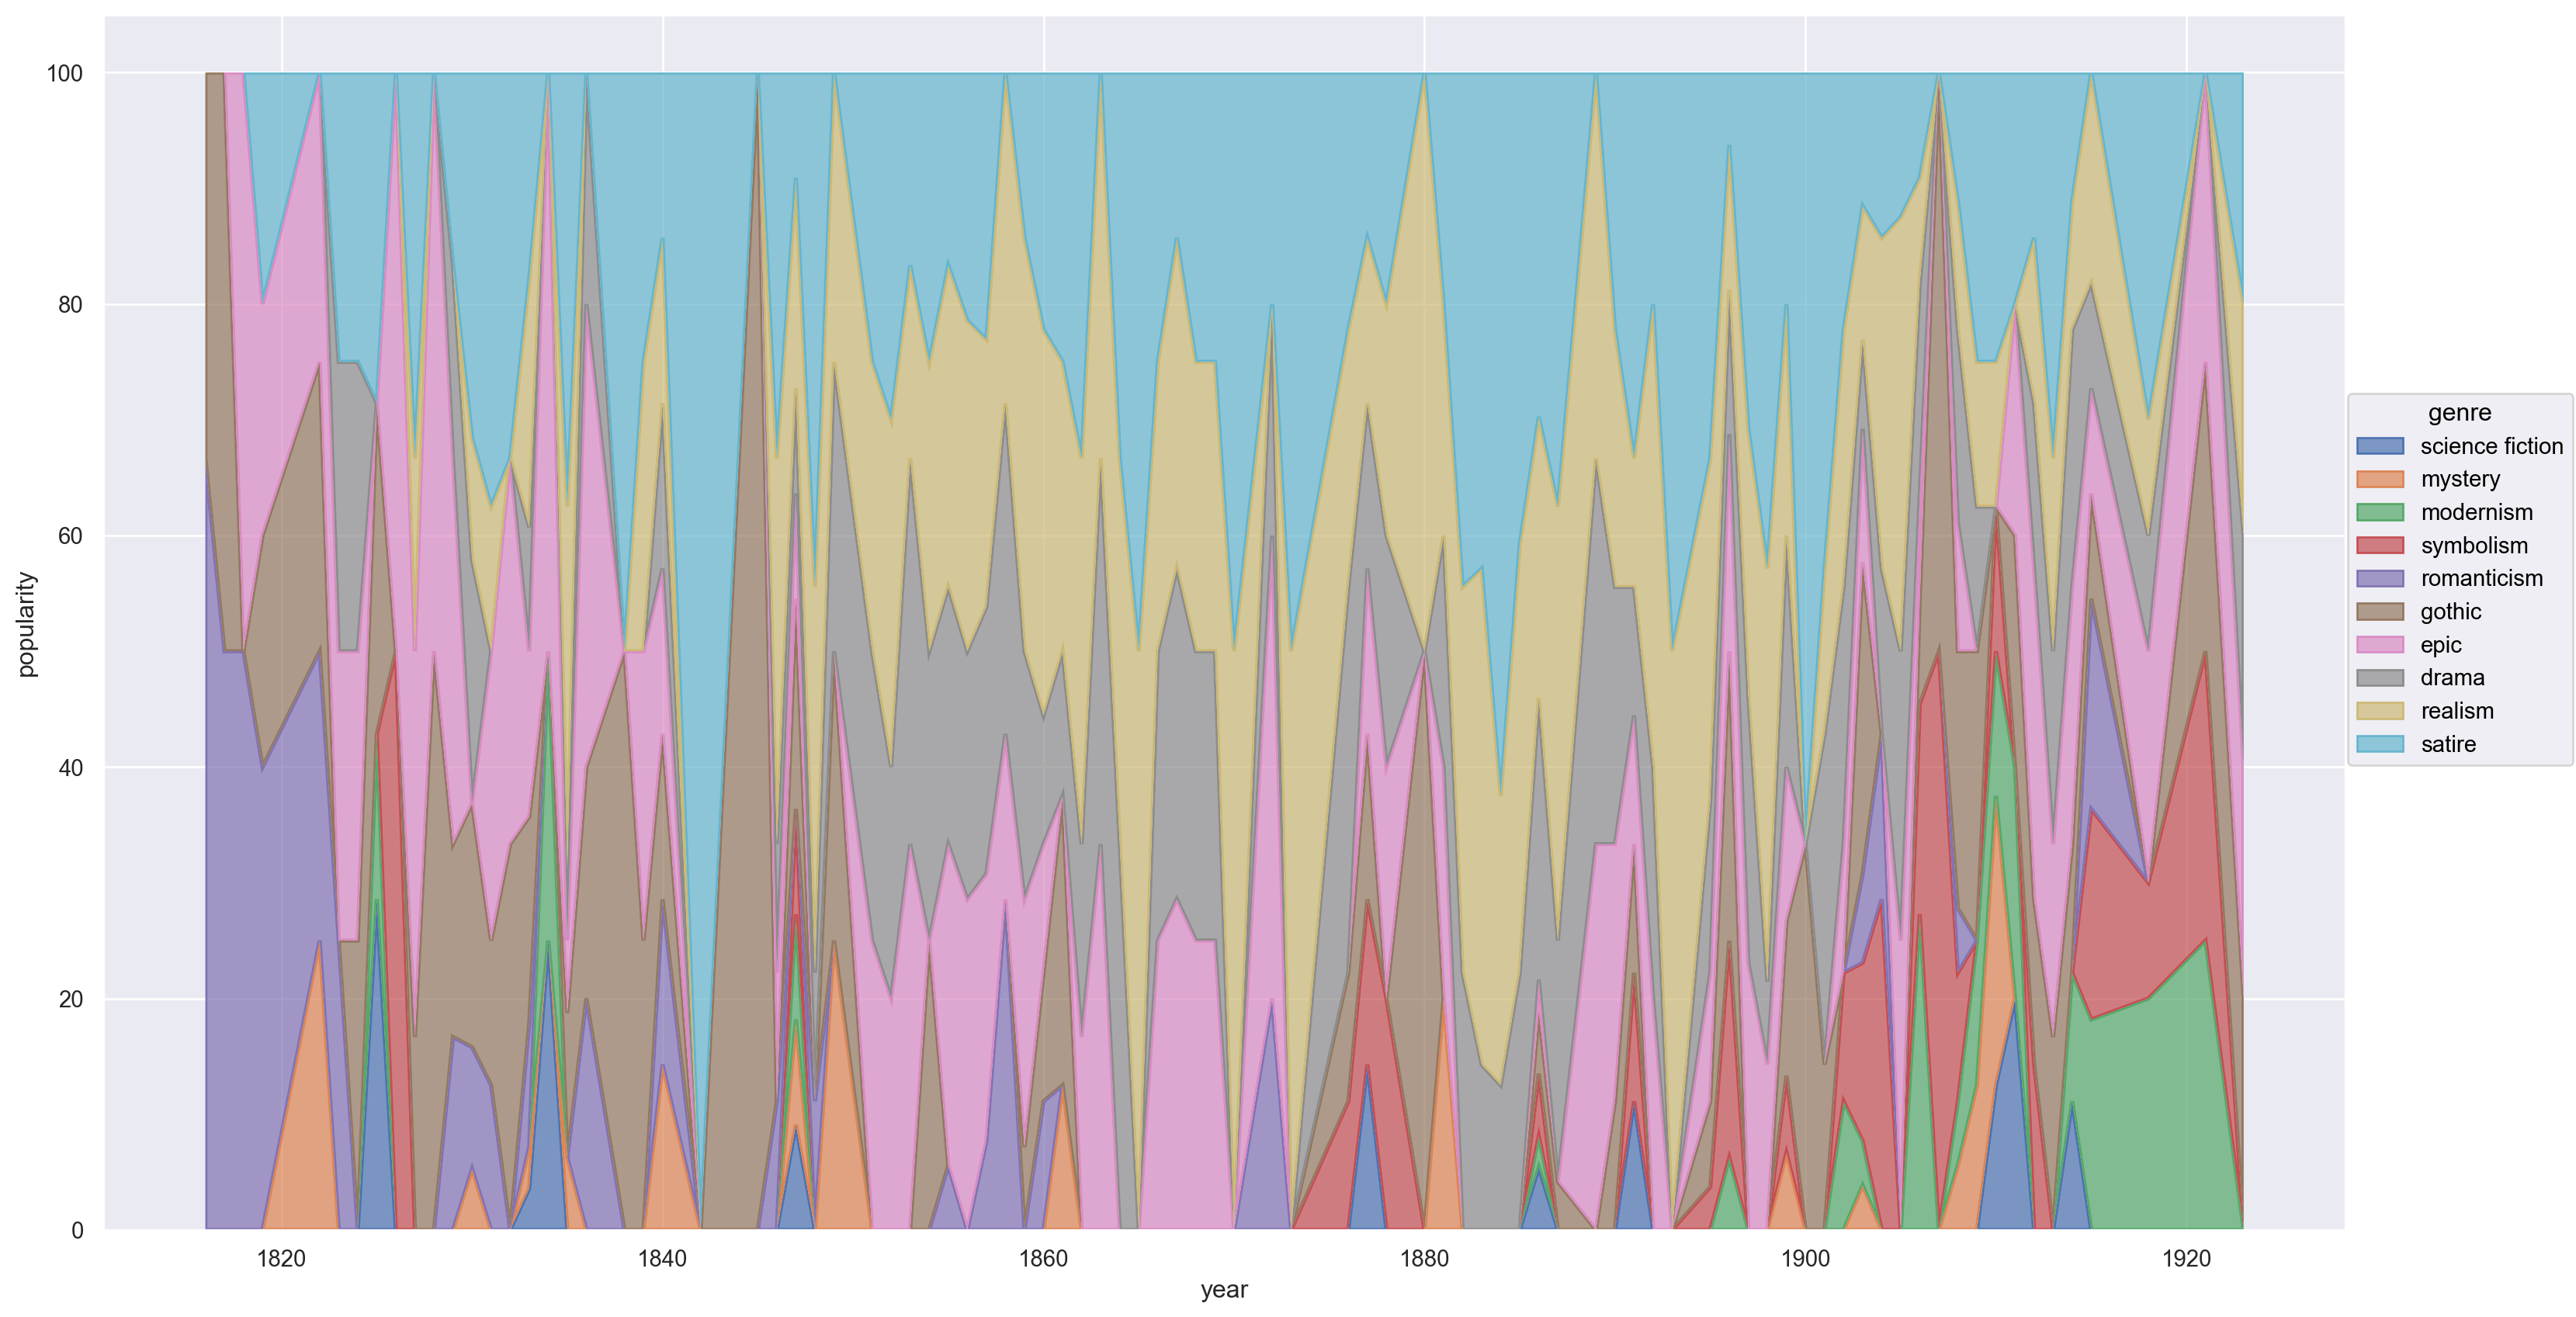

In [22]:
genre_trends = df.explode("genres_list").groupby(["year", "genres_list"]).size().unstack(fill_value=0)
filtered_genre_trends = genre_trends[genre_trends.sum().sort_values().index[-10:]]
percentage_filtered_genre_trends = (
    filtered_genre_trends.divide(filtered_genre_trends.sum(axis=1), axis=0) * 100
).reset_index()
melted_percentage_filtered_genre_trends = percentage_filtered_genre_trends.melt(
    id_vars="year", var_name="genre", value_name="popularity"
)

so.Plot(
    melted_percentage_filtered_genre_trends, "year", "popularity", color="genre"
).add(so.Area(alpha=0.7), so.Stack()).layout(size=(16, 9)).save(
    "gemini1.png", bbox_inches="tight"
)

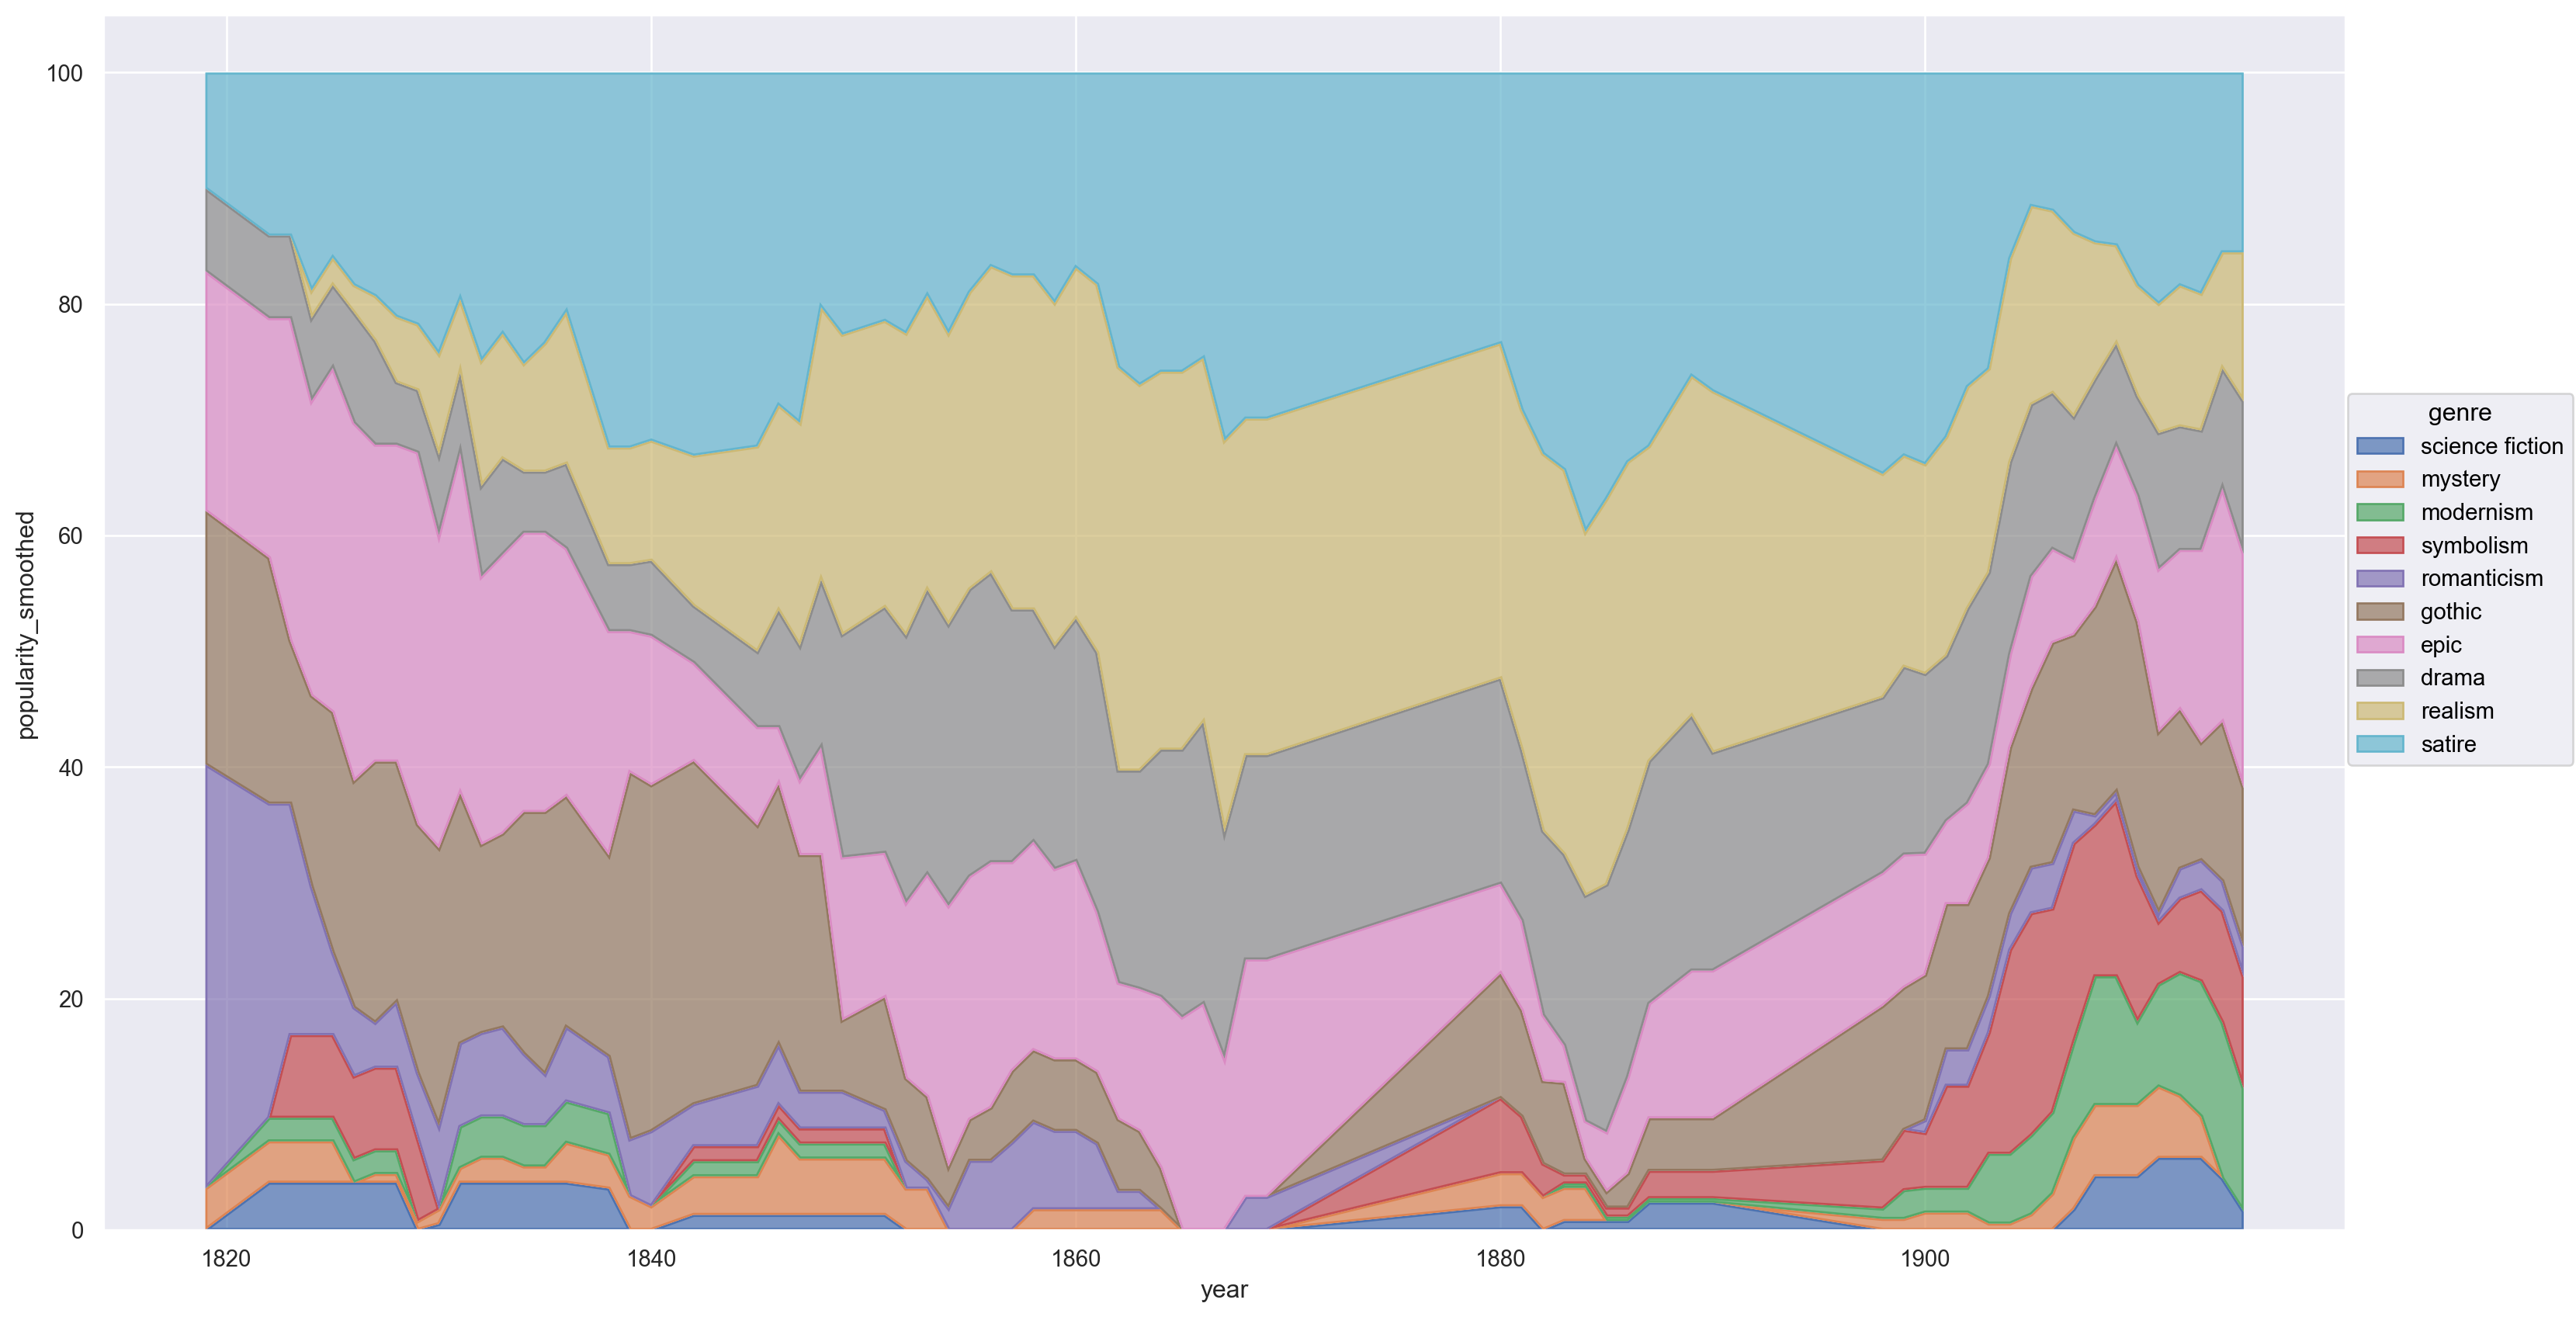

In [27]:
genre_trends = df.explode("genres_list").groupby(["year", "genres_list"]).size().unstack(fill_value=0)
filtered_genre_trends = genre_trends[genre_trends.sum().sort_values().index[-10:]]
percentage_filtered_genre_trends = (
    filtered_genre_trends.divide(filtered_genre_trends.sum(axis=1), axis=0) * 100
).reset_index()
melted_percentage_filtered_genre_trends = percentage_filtered_genre_trends.melt(
    id_vars="year", var_name="genre", value_name="popularity"
)

melted_percentage_filtered_genre_trends["popularity_smoothed"] = (
    melted_percentage_filtered_genre_trends.groupby("genre")["popularity"].transform(
        lambda x: x.rolling(window=7, center=True).mean()
    )
)

so.Plot(
    melted_percentage_filtered_genre_trends,
    "year",
    "popularity_smoothed",
    color="genre",
).add(so.Area(alpha=0.7), so.Stack()).layout(size=(16, 9)).save(
    "gemini2.png", bbox_inches="tight"
)

In [24]:
melted_percentage_filtered_genre_trends[melted_percentage_filtered_genre_trends["year"] == 1915]

,year,genre,popularity,popularity_smoothed
88,1915,science fiction,0.000000,1.587302
181,1915,mystery,0.000000,0.000000
274,1915,modernism,18.181818,10.613276
367,1915,symbolism,18.181818,9.638219
460,1915,romanticism,18.181818,2.597403
553,1915,gothic,9.090909,13.736343
646,1915,epic,9.090909,20.221604
739,1915,drama,9.090909,13.180787
832,1915,realism,18.181818,12.892187
925,1915,satire,0.000000,15.532880


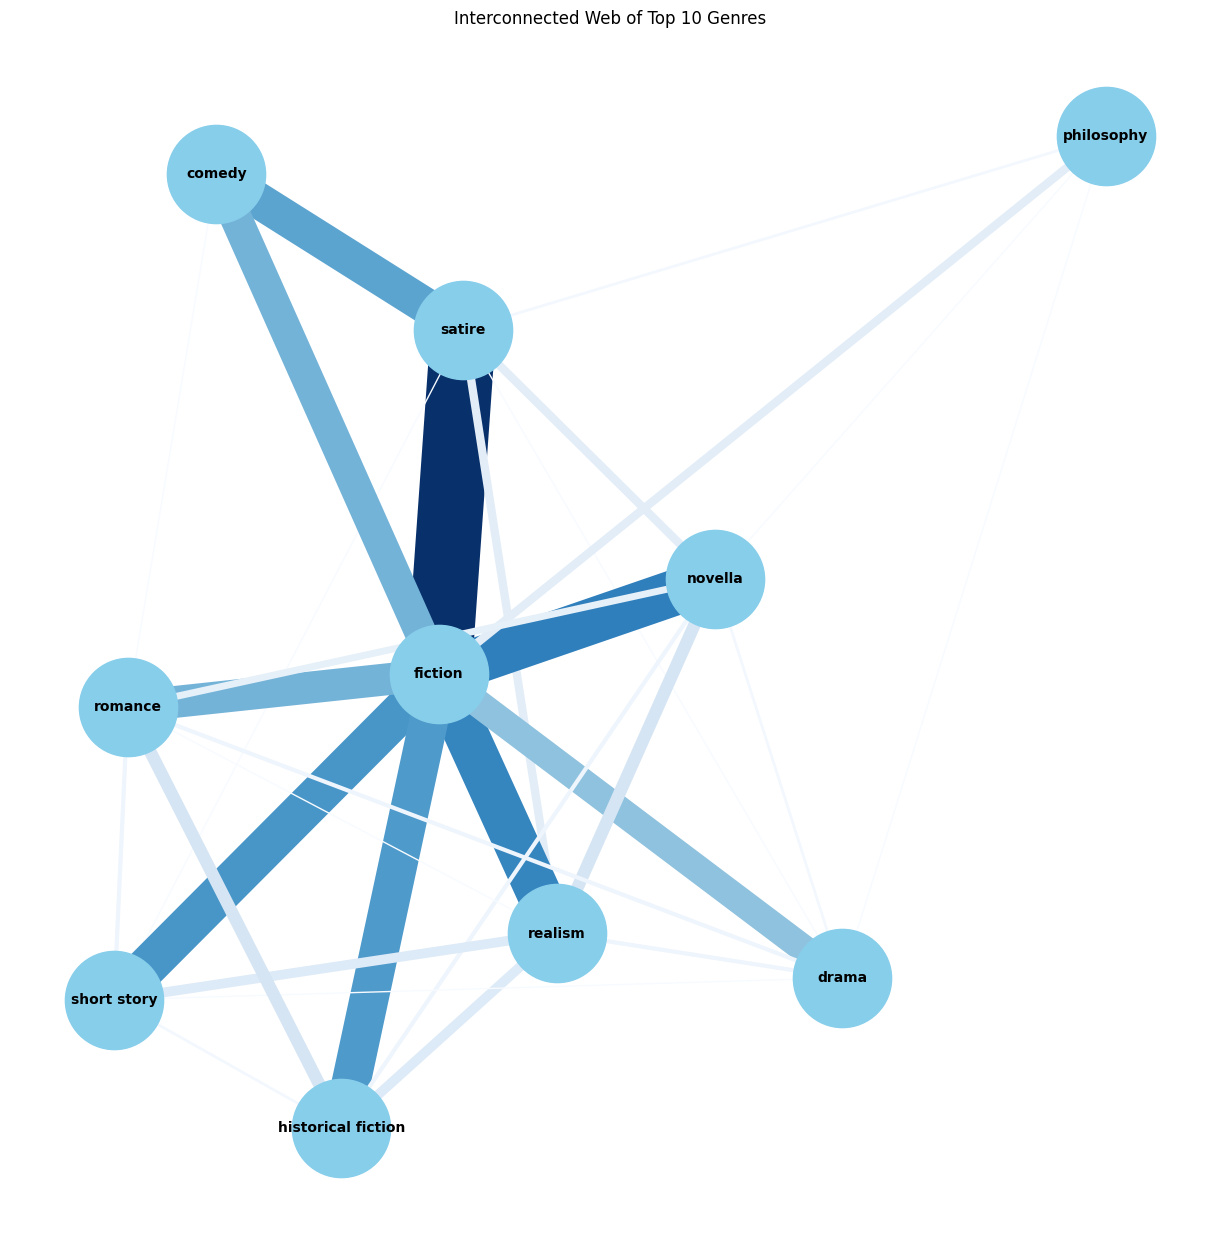

In [16]:
top_genres = df['genres_list'].explode("genres_list").value_counts().head(10).index
genre_pairs = df['genres_list'].apply(lambda x: [frozenset([a, b]) for i, a in enumerate(x) for b in x[i+1:] if a in top_genres and b in top_genres])
genre_connections = genre_pairs.explode().value_counts()

G = nx.Graph()
for connection, weight in genre_connections.items():
    genre1, genre2 = list(connection)
    G.add_edge(genre1, genre2, weight=weight)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.3)
weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw(G, pos, with_labels=True, node_size=5000, node_color='skyblue', font_size=10, font_weight='bold', width=weights, edge_color=weights, edge_cmap=plt.cm.Blues)
plt.title("Interconnected Web of Top 10 Genres")
plt.savefig("net.png")

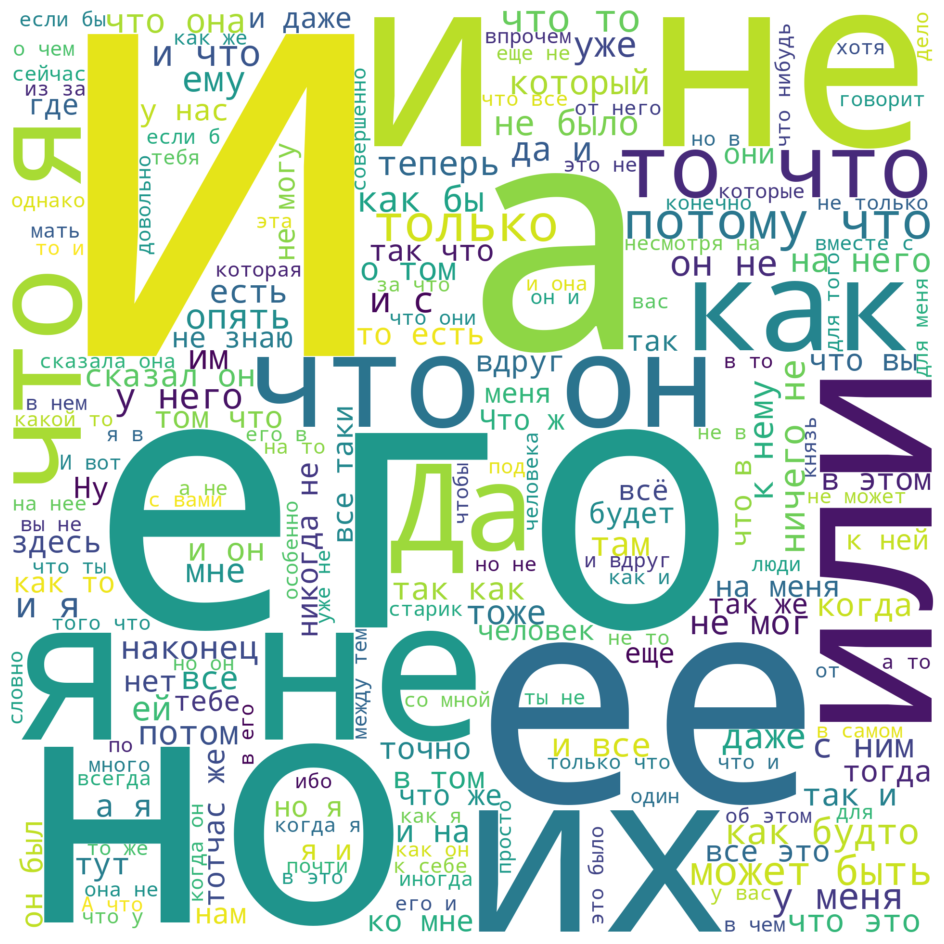

In [19]:
wordcloud = WordCloud(width=1920, height=1920, background_color='white').generate(' '.join(df['text']))

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("wordcloud.png")

In [24]:
gemini_pro.generate_content(
    "\"The play portrays the visit of an elderly professor and his glamorous, much younger second wife, Yelena, to the rural estate that supports their urban lifestyle. Two friends—Vanya, brother of the professor's late first wife, who has long managed the estate, and Astrov, the local doctor—both fall under Yelena's spell while bemoaning the ennui of their provincial existence. Sonya, the professor's daughter by his first wife, who has worked with Vanya to keep the estate going, suffers from her unrequited feelings for Astrov. Matters are brought to a crisis when the professor announces his intention to sell the estate, Vanya and Sonya's home, with a view to investing the proceeds to achieve a higher income for himself and his wife.\"\nPlease repeat each sentance followed by a comma-separated list of single-word genres that best describe it"
).candidates[0].content.parts[0].text

'"The play portrays the visit of an elderly professor and his glamorous, much younger second wife, Yelena, to the rural estate that supports their urban lifestyle.", drama, romance\n"Two friends—Vanya, brother of the professor\'s late first wife, who has long managed the estate, and Astrov, the local doctor—both fall under Yelena\'s spell while bemoaning the ennui of their provincial existence.", drama, romance\n"Sonya, the professor\'s daughter by his first wife, who has worked with Vanya to keep the estate going, suffers from her unrequited feelings for Astrov.", drama, romance\n"Matters are brought to a crisis when the professor announces his intention to sell the estate, Vanya and Sonya\'s home, with a view to investing the proceeds to achieve a higher income for himself and his wife.", drama, family'

In [21]:
gemini_pro.generate_content(
    "\"The play portrays the visit of an elderly professor and his glamorous, much younger second wife, Yelena, to the rural estate that supports their urban lifestyle. Two friends—Vanya, brother of the professor's late first wife, who has long managed the estate, and Astrov, the local doctor—both fall under Yelena's spell while bemoaning the ennui of their provincial existence. Sonya, the professor's daughter by his first wife, who has worked with Vanya to keep the estate going, suffers from her unrequited feelings for Astrov. Matters are brought to a crisis when the professor announces his intention to sell the estate, Vanya and Sonya's home, with a view to investing the proceeds to achieve a higher income for himself and his wife.\"\nRewrite the abstract like Uncle Vanya was a political commentary satire of Russia in 1870:"
).candidates[0].content.parts[0].text

'"This play is a thinly veiled critique of the stagnant Russian aristocracy in the late 19th century.  The aging professor, clinging to outdated ideas and obsessed with financial gain, represents the out-of-touch ruling class. His glamorous young wife, Yelena, embodies the allure of superficial modernity and the seductive power of wealth and status. Vanya and Astrov, trapped in the suffocating tedium of provincial life, stand in for the frustrated intelligentsia, yearning for change but paralyzed by inertia.  Sonya, the tireless worker exploited by her father, embodies the plight of the common people, toiling away with little reward. The professor\'s plan to sell the estate, the very foundation of their existence, exposes the callous disregard of the ruling class for the well-being of the people and the future of the nation." \n'